## AUC Per Label and Overall (Before and After)


### Goal: Report AUC for each of the 14 labels and an average AUC across all labels for both Baseline and Debiased Predictions

## Initial setup

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
baseline = pd.read_csv("BaseLine/baseline_test_predictions.csv")
baseline.head()

,subject_id,study_id,Enlarged Cardiomediastinum_ground_truth,Cardiomegaly_ground_truth,Lung Opacity_ground_truth,Lung Lesion_ground_truth,Edema_ground_truth,Consolidation_ground_truth,Pneumonia_ground_truth,Atelectasis_ground_truth,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10001176,tensor(53186264),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
1,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
2,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
3,10001217,tensor(52067803),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0
4,10001217,tensor(58913004),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0


In [16]:
# Data Frames for all the Debiasing Techniques
df_debiased_lwbc_comitee20 = pd.read_csv("LWBC_Debiased/test_predictions_committee20.csv")
df_debiased_ensembelearning = pd.read_csv("Ensemble_Debiased/EnsembeLearning_Debiased_Results.csv")
df_debiased_adversarial = pd.read_csv("Adversarial_Debiased/Adversarial_Debiased.csv")
df_debiased_finetune = pd.read_csv("FineTuned_Baseline_Debiased/FineTuned_Baseline_Debiased_Results.csv")

In [17]:
# list of all column labels from dataset
labels = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"]


In [18]:
def get_label_data(baseline, label):
    y_true = baseline[f"{label}_ground_truth"]                            # adding "groud_truth" suffix
    y_prob = baseline[f"{label}_probability"]                             # adding "probability" suffix
    return y_true, y_prob

In [19]:
#BEFORE
def find_all_aucs_baseline(baseline):
    """
    Calculate and record AUC for each label using baseline_test_predictions.csv.
    Compute the average AUC across all labels.

    Parameters:
        df: baseline datafram 
    """
    all_aucs_baseline = {}
    print(f"----Area Under Curve for All Labels in Baseline Predictions----")
    for label in labels:
        y_true, y_prob = get_label_data(baseline, label)
    
        try:
            auc_baseline = roc_auc_score(y_true, y_prob)
            print(f"AUC for {label}: {auc_baseline}")
        except ValueError:
            print(f"Warning: Only one class in y_true {label}, cant calculate AUC")
            auc_baseline = None
        
        all_aucs_baseline[label] = auc_baseline

    return all_aucs_baseline
       
all_aucs_baseline = find_all_aucs_baseline(baseline)
mean_auc = np.mean([value for value in all_aucs_baseline.values() if value is not None])
print(f"\nAverage AUC for all labels: {mean_auc}")

----Area Under Curve for All Labels in Baseline Predictions----
AUC for Enlarged Cardiomediastinum: 0.7121739530887361
AUC for Cardiomegaly: 0.8026875857944425
AUC for Lung Opacity: 0.7680117389737212
AUC for Lung Lesion: 0.7875807064156755
AUC for Edema: 0.892258706836114
AUC for Consolidation: 0.8254991266096144
AUC for Pneumonia: 0.73795017242151
AUC for Atelectasis: 0.8064520945898295
AUC for Pneumothorax: 0.8742500656458692
AUC for Pleural Effusion: 0.9074102885324271
AUC for Pleural Other: 0.8535141143755465
AUC for Fracture: 0.7510334155932521
AUC for Support Devices: 0.928507624603063
AUC for No Finding: 0.8667067932127452

Average AUC for all labels: 0.8224311704780389


In [20]:
#AFTER
def find_all_aucs_debiased_lwbc(df_debiased_lwbc_comitee20):
    """
    Calculate and record AUC for each label using test_predictions_committee20.csv debiasing technique.
    Compute the average AUC across all labels.

    Parameters:
        df: debiased dataframe
        labels: holds the label names from the df
    """
    all_aucs_debiased = {}
    print(f"----Area Under Curve for All Labels in Debiased Predictions (lwbc committee20)----")
    for label in labels:
        y_true, y_prob = get_label_data(df_debiased_lwbc_comitee20, label)
    
        try:
            auc_debias = roc_auc_score(y_true, y_prob)
            print(f"AUC for {label}: {auc_debias}")
        except ValueError:
            print(f"Warning: Only one class in y_true {label}, cant calculate AUC")
            auc_debias = None
        
        all_aucs_debiased[label] = auc_debias

    return all_aucs_debiased
       
all_aucs_debiased = find_all_aucs_debiased_lwbc(df_debiased_lwbc_comitee20)
mean_auc = np.mean([value for value in all_aucs_debiased.values() if value is not None])
print(f"\nAverage AUC for all labels: {mean_auc}")

----Area Under Curve for All Labels in Debiased Predictions (lwbc committee20)----
AUC for Enlarged Cardiomediastinum: 0.7297126226135734
AUC for Cardiomegaly: 0.8049012350460819
AUC for Lung Opacity: 0.7709385088528048
AUC for Lung Lesion: 0.8050816536007559
AUC for Edema: 0.8926104007331068
AUC for Consolidation: 0.8275370535450123
AUC for Pneumonia: 0.7436971648841461
AUC for Atelectasis: 0.80933482166852
AUC for Pneumothorax: 0.88544684306734
AUC for Pleural Effusion: 0.9102330283137985
AUC for Pleural Other: 0.8739088654178913
AUC for Fracture: 0.802449941765749
AUC for Support Devices: 0.9293407385528691
AUC for No Finding: 0.8680109357498629

Average AUC for all labels: 0.8323717009865367


In [21]:
def find_all_aucs_debiased_ensemble(df_debiased_ensembelearning):
    """
    Calculate and record AUC for each label using EnsembeLearning_Debiased_Results.csv debiasing technique.
    Compute the average AUC across all labels.

    Parameters:
        df: debiased dataframe
        labels: holds the label names from the df
    """
    all_aucs_debiased = {}
    print(f"----Area Under Curve for All Labels in Debiased Predictions (ensemble learning)----")
    for label in labels:
        y_true, y_prob = get_label_data(df_debiased_ensembelearning, label)
    
        try:
            auc_debias = roc_auc_score(y_true, y_prob)
            print(f"AUC for {label}: {auc_debias}")
        except ValueError:
            print(f"Warning: Only one class in y_true {label}, cant calculate AUC")
            auc_debias = None
        
        all_aucs_debiased[label] = auc_debias

    return all_aucs_debiased
       
all_aucs_debiased = find_all_aucs_debiased_ensemble(df_debiased_ensembelearning)
mean_auc = np.mean([value for value in all_aucs_debiased.values() if value is not None])
print(f"\nAverage AUC for all labels: {mean_auc}")

----Area Under Curve for All Labels in Debiased Predictions (ensemble learning)----
AUC for Enlarged Cardiomediastinum: 0.5385717430951895
AUC for Cardiomegaly: 0.7824010233295234
AUC for Lung Opacity: 0.7056171670398982
AUC for Lung Lesion: 0.7083969744868907
AUC for Edema: 0.8669362404379553
AUC for Consolidation: 0.7878861162439066
AUC for Pneumonia: 0.6888161673653901
AUC for Atelectasis: 0.7871150383214078
AUC for Pneumothorax: 0.840227357751231
AUC for Pleural Effusion: 0.8929806083904884
AUC for Pleural Other: 0.7566819346065711
AUC for Fracture: 0.6924388360003553
AUC for Support Devices: 0.9216173548559157
AUC for No Finding: 0.8654119847397981

Average AUC for all labels: 0.773935610476037


In [22]:
def find_all_aucs_debiased_adv(df_debiased_adversarial):
    """
    Calculate and record AUC for each label using Adversarial_Debiased.csv debiasing technique.
    Compute the average AUC across all labels.

    Parameters:
        df: debiased dataframe
        labels: holds the label names from the df
    """
    all_aucs_debiased = {}
    print(f"----Area Under Curve for All Labels in Debiased Predictions (adveserial)----")
    for label in labels:
        y_true, y_prob = get_label_data(df_debiased_adversarial, label)
    
        try:
            auc_debias = roc_auc_score(y_true, y_prob)
            print(f"AUC for {label}: {auc_debias}")
        except ValueError:
            print(f"Warning: Only one class in y_true {label}, cant calculate AUC")
            auc_debias = None
        
        all_aucs_debiased[label] = auc_debias

    return all_aucs_debiased
       
all_aucs_debiased = find_all_aucs_debiased_adv(df_debiased_adversarial)
mean_auc = np.mean([value for value in all_aucs_debiased.values() if value is not None])
print(f"\nAverage AUC for all labels: {mean_auc}")

----Area Under Curve for All Labels in Debiased Predictions (adveserial)----
AUC for Enlarged Cardiomediastinum: 0.7223374820128908
AUC for Cardiomegaly: 0.7910196466401404
AUC for Lung Opacity: 0.7596409399293058
AUC for Lung Lesion: 0.7776938553315343
AUC for Edema: 0.8833071327694805
AUC for Consolidation: 0.8167751569384623
AUC for Pneumonia: 0.733372291943082
AUC for Atelectasis: 0.794370057459069
AUC for Pneumothorax: 0.8737110851794438
AUC for Pleural Effusion: 0.903482389130305
AUC for Pleural Other: 0.8512554005878142
AUC for Fracture: 0.7575308294333896
AUC for Support Devices: 0.9257770896323865
AUC for No Finding: 0.8630994604116521

Average AUC for all labels: 0.8180980583856396


In [23]:
def find_all_aucs_debiased_fine(df_debiased_finetune):
    """
    Calculate and record AUC for each label using FineTuned_Baseline_Debiased_Results.csv debiasing technique.
    Compute the average AUC across all labels.

    Parameters:
        df: debiased dataframe
        labels: holds the label names from the df
    """
    all_aucs_debiased = {}
    print(f"----Area Under Curve for All Labels in Debiased Predictions (finetune)----")
    for label in labels:
        y_true, y_prob = get_label_data(df_debiased_finetune, label)
    
        try:
            auc_debias = roc_auc_score(y_true, y_prob)
            print(f"AUC for {label}: {auc_debias}")
        except ValueError:
            print(f"Warning: Only one class in y_true {label}, cant calculate AUC")
            auc_debias = None
        
        all_aucs_debiased[label] = auc_debias

    return all_aucs_debiased
       
all_aucs_debiased = find_all_aucs_debiased_fine(df_debiased_finetune)
mean_auc = np.mean([value for value in all_aucs_debiased.values() if value is not None])
print(f"\nAverage AUC for all labels: {mean_auc}")

----Area Under Curve for All Labels in Debiased Predictions (finetune)----
AUC for Enlarged Cardiomediastinum: 0.7062622897455971
AUC for Cardiomegaly: 0.8010682659527606
AUC for Lung Opacity: 0.762335981912833
AUC for Lung Lesion: 0.7807570601602891
AUC for Edema: 0.8872736073729074
AUC for Consolidation: 0.819634470127932
AUC for Pneumonia: 0.7394761111451227
AUC for Atelectasis: 0.8029406257666792
AUC for Pneumothorax: 0.8624250141683555
AUC for Pleural Effusion: 0.9056070737808378
AUC for Pleural Other: 0.8484445992323161
AUC for Fracture: 0.7553055618556865
AUC for Support Devices: 0.9272974179802236
AUC for No Finding: 0.8610593368445302

Average AUC for all labels: 0.8185633868604336


### Comparison:
- Create a comparison table & plot: baseline vs. debiased per-label AUCs.
- Include the difference and whether it improved.
- Include the average AUC across all labels in both models.

----Area Under Curve for All Labels in Debiased Predictions (lwbc committee20)----
AUC for Enlarged Cardiomediastinum: 0.7297126226135734
AUC for Cardiomegaly: 0.8049012350460819
AUC for Lung Opacity: 0.7709385088528048
AUC for Lung Lesion: 0.8050816536007559
AUC for Edema: 0.8926104007331068
AUC for Consolidation: 0.8275370535450123
AUC for Pneumonia: 0.7436971648841461
AUC for Atelectasis: 0.80933482166852
AUC for Pneumothorax: 0.88544684306734
AUC for Pleural Effusion: 0.9102330283137985
AUC for Pleural Other: 0.8739088654178913
AUC for Fracture: 0.802449941765749
AUC for Support Devices: 0.9293407385528691
AUC for No Finding: 0.8680109357498629
----Area Under Curve for All Labels in Debiased Predictions (ensemble learning)----
AUC for Enlarged Cardiomediastinum: 0.5385717430951895
AUC for Cardiomegaly: 0.7824010233295234
AUC for Lung Opacity: 0.7056171670398982
AUC for Lung Lesion: 0.7083969744868907
AUC for Edema: 0.8669362404379553
AUC for Consolidation: 0.7878861162439066
AUC fo

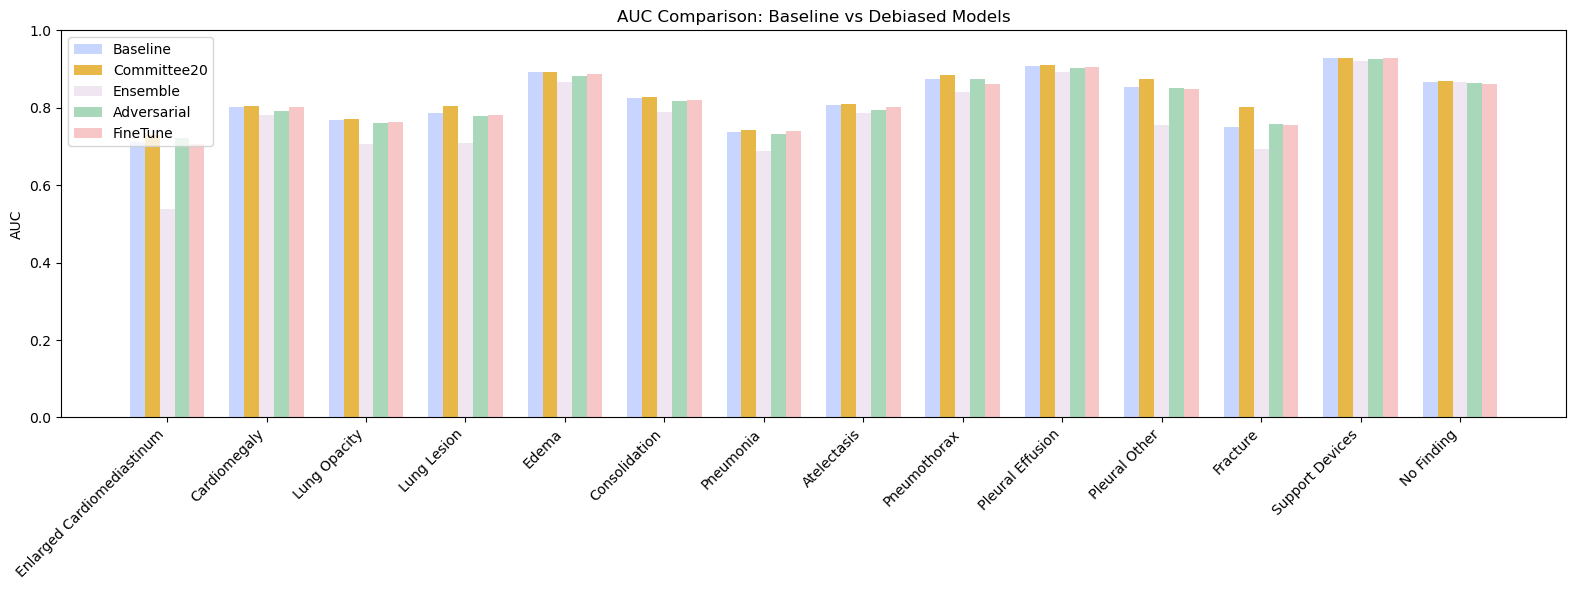

In [ ]:
def auc_baseline_debiased_comparison_plot(baseline_auc_per_label_dict, list_of_all_debiased_auc_dicts, debiasing_method_names, title = "Baseline vs Debiased AUCs"):
    """
    Compare AUCs across a baseline and multiple debiasing techniques.
    
    Parameters:
    - baseline_auc_dict: dict of {label: AUC} from baseline
    - debiased_auc_dicts: list of dicts [{label: AUC}, ...] from debiased models
    - method_names: list of names matching each debiased model
    """

    comparable_labels = []

    # finds labels with valid AUCs in baseline and all debiased methods
    for label in baseline_auc_per_label_dict:
        if baseline_auc_per_label_dict[label] is not None and all(
            debiased_auc_dict.get(label) is not None for debiased_auc_dict in list_of_all_debiased_auc_dicts
        ):
            comparable_labels.append(label)

    # collects AUCs per method for those valid labels
    aucs_baseline_model = [baseline_auc_per_label_dict[label] for label in comparable_labels]
    aucs_all_models = [aucs_baseline_model] + [
        [debiased_auc_dict[label] for label in comparable_labels]
        for debiased_auc_dict in list_of_all_debiased_auc_dicts
    ]

    # builds the comparison table
    comparison_table_data = []
    for i, label in enumerate(comparable_labels):
        row = {
            "Label": label,
            "Baseline AUC": aucs_baseline_model[i]
        }
        for method_name, debiased_auc_dict in zip(debiasing_method_names, list_of_all_debiased_auc_dicts):
            auc_debiased = debiased_auc_dict[label]
            row[f"{method_name} AUC"] = auc_debiased
            row[f"{method_name} Diff"] = auc_debiased - aucs_baseline_model[i]
            row[f"{method_name} Improved"] = "Yes" if auc_debiased > aucs_baseline_model[i] else "No"
        comparison_table_data.append(row)

    average_row = {
        "Label": "Average",
        "Baseline AUC": np.mean(aucs_baseline_model)
    }
    for method_name, auc_list in zip(debiasing_method_names, aucs_all_models[1:]):
        average_auc = np.mean(auc_list)
        diff_from_baseline = average_auc - average_row["Baseline AUC"]
        average_row[f"{method_name} AUC"] = average_auc
        average_row[f"{method_name} Diff"] = diff_from_baseline
        average_row[f"{method_name} Improved"] = "Yes" if diff_from_baseline > 0 else "No"
    comparison_table_data.append(average_row)

    df_comparison = pd.DataFrame(comparison_table_data)

    print("\n--- AUC Comparison Table ---")
    print(df_comparison.to_string(index=False))


    # --- plotting setup ---
    x = np.arange(len(comparable_labels))
    bar_width = 0.15
    center_offset = -(bar_width * len(list_of_all_debiased_auc_dicts)) / 2
    pastel_colors = ['#c7d5ff', '#e7b847', '#f0e6f1', '#a8d8b9', '#f7c6c7', '#ffd8be']

    plt.figure(figsize=(16, 6))
    plt.bar(x + center_offset, aucs_baseline_model, bar_width, label='Baseline', color=pastel_colors[0])

    for i, (method_name, aucs_method) in enumerate(zip(debiasing_method_names, aucs_all_models[1:])):
        color = pastel_colors[i + 1] if i + 1 < len(pastel_colors) else None
        plt.bar(x + center_offset + (bar_width * (i + 1)), aucs_method, bar_width, label=method_name, color=color)

    plt.xticks(x, comparable_labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("AUC")
    plt.legend()
    plt.tight_layout()
    plt.show()

# function calls
auc_baseline_debiased_comparison_plot(
    baseline_auc_per_label_dict=all_aucs_baseline,
    list_of_all_debiased_auc_dicts=[
        find_all_aucs_debiased_lwbc(df_debiased_lwbc_comitee20),
        find_all_aucs_debiased_ensemble(df_debiased_ensembelearning),
        find_all_aucs_debiased_adv(df_debiased_adversarial),
        find_all_aucs_debiased_fine(df_debiased_finetune)
    ],
    debiasing_method_names = ["Committee20", "Ensemble", "Adversarial", "FineTune"],
    title = "AUC Comparison: Baseline vs Debiased Models"
)